# Classification on MNIST


In [89]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import (
    confusion_matrix,
    precision_recall_curve,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import ClassifierChain

In [2]:
%matplotlib inline

In [3]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", as_frame=False)

`There are 70,000 images, and each image has 784 features. This is because
each image is 28 × 28 pixels, and each feature simply represents one pixel’s
intensity, from 0 (white) to 255 (black)`


In [4]:
X, y = mnist.data, mnist.target

In [5]:
X.shape, y.shape

((70000, 784), (70000,))

In [6]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [7]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

# Visualization

`All we need to do is grab an instance’s feature
vector, reshape it to a 28 × 28 array, and display it using Matplotlib’s
imshow() function. We use cmap="binary" to get a grayscale color map
where 0 is white and 255 is black:`


In [8]:
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.gca().axis(
        "off"
    )  # Using plt.gca() cause without it there was a bool func is not callable error
    plt.show()

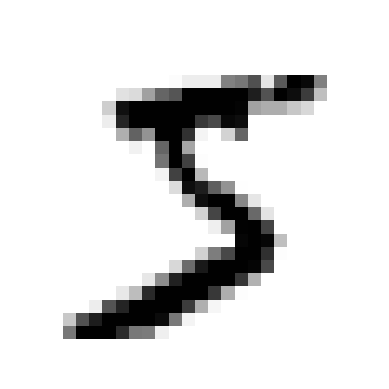

In [9]:
plot_digit(X[0])

# Making and putting aside the test set

`The MNIST dataset returned by fetch_openml() is
actually already split into a training set (the first 60,000 images) and a test set
(the last 10,000 images):`


In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
# The training set is already shuffled for us, which is good because this guarantees that all cross-validation folds will be similar

# Training a Binary Classifier


In [11]:
y_tr_4 = y_train == "4"
y_ts_4 = y_test == "4"

In [12]:
y_tr_5 = y_train == "5"
y_ts_5 = y_test == "5"

In [13]:
# using SGD
sgd_cl = SGDClassifier(random_state=42)
sgd_cl.fit(X_train, y_tr_4)

SGDClassifier(random_state=42)

In [14]:
sgd_cl_5 = SGDClassifier(random_state=42)
sgd_cl_5.fit(X_train, y_tr_5)

SGDClassifier(random_state=42)

<img src="download.png">


In [15]:
a = []
for i in range(0, 10):
    some_digit = X[i]
    a.append(sgd_cl.predict([some_digit])[0])
    i += 1
a
# can match with above image

[False, False, True, False, False, False, False, False, False, True]

# Performance Measure


In [16]:
# Cross-Validation
cross_val_score(sgd_cl, X_train, y_tr_4, cv=3, scoring="accuracy")

array([0.9671 , 0.97645, 0.9687 ])

In [17]:
# now with a dummy classifier
dummy_cl = DummyClassifier(random_state=42)
dummy_cl.fit(X_train, y_tr_4)
print(any(dummy_cl.predict(X_train)))

False


In [18]:
cross_val_score(dummy_cl, X_train, y_tr_4, cv=3, scoring="accuracy")

array([0.90265, 0.90265, 0.9026 ])

# Implement Cross_val manually

<img src="Cross_val.png">


# Confusion matrix


In [19]:
y_train_pred = cross_val_predict(sgd_cl_5, X_train, y_tr_5, cv=3)

In [20]:
# building Confusion Matrix
cm = confusion_matrix(y_tr_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [21]:
# pretending to be a true classifier
y_train_pred_pref = y_tr_5
cm = confusion_matrix(y_tr_5, y_train_pred_pref)
cm

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [22]:
precision_score(y_tr_5, y_train_pred), recall_score(y_tr_5, y_train_pred), f1_score(
    y_tr_5, y_train_pred
)

(0.8370879772350012, 0.6511713705958311, 0.7325171197343847)

# Precision Recall tradeoff and THRESHOLD


In [23]:
y_scores = cross_val_predict(
    sgd_cl_5, X_train, y_tr_5, cv=3, method="decision_function"
)

In [24]:
precisons, recalls, thresholds = precision_recall_curve(y_tr_5, y_scores)

In [25]:
threshold = 3000

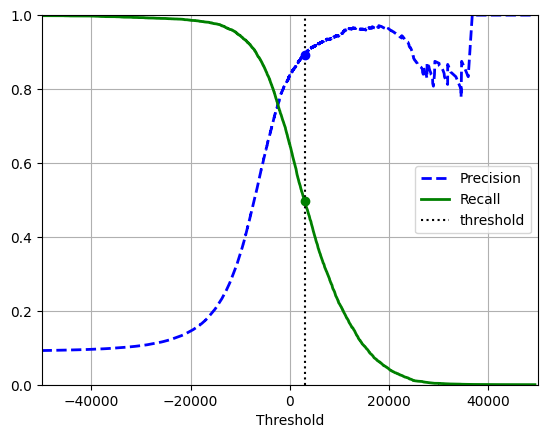

In [26]:
# ploting 
%matplotlib inline
plt.plot(thresholds,precisons[:-1],"b--",label="Precision",linewidth=2)
plt.plot(thresholds,recalls[:-1],"g-",label="Recall",linewidth=2)
plt.vlines(threshold,0,1.0,"k","dotted",label="threshold")

# extra code – this section just beautifies and saves Figure 3–5.... Copied from book
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisons[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.gca().axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")

`You may wonder why the precision curve is bumpier than the recall curve....The reason is that precision may sometimes go down when you raise the threshold
(although in general it will go up)....On the other hand, recall can
only go down when the threshold is increased, which explains why its curve looks smooth.
`


Text(0.56, 0.62, 'Higher\nthreshold')

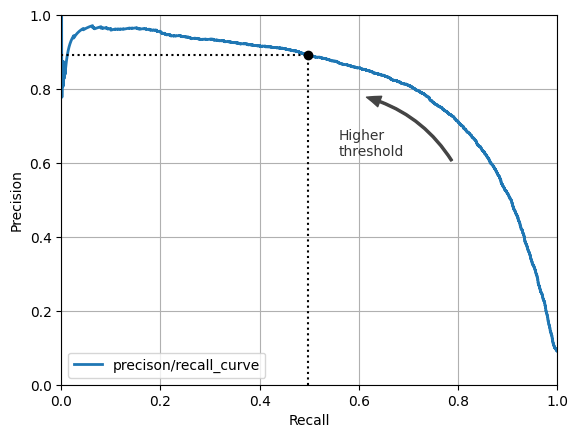

In [27]:
# Another way to select a good precision/recall trade-off is to plot precision directly against recall

plt.plot(recalls, precisons, linewidth=2, label="precison/recall_curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.gca().axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
plt.plot([recalls[idx], recalls[idx]], [0.0, precisons[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisons[idx], precisons[idx]], "k:")
plt.plot([recalls[idx]], [precisons[idx]], "ko", label="Point at threshold 3,000")
plt.gca().add_patch(
    patches.FancyArrowPatch(
        (0.79, 0.60),
        (0.61, 0.78),
        connectionstyle="arc3,rad=.2",
        arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
        color="#444444",
    )
)
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")

In [28]:
# we try to get a threshold value that provides 90% precision

idx_for_90 = (precisons >= 0.90).argmax()
threshold_for_90 = thresholds[idx_for_90]
threshold_for_90

3370.0194991439557

In [29]:
# to make prediction on training set you can call (for 90 precision)
y_train_pred_90 = y_scores >= threshold_for_90

# get scores too if u want

precision_score(y_tr_5, y_train_pred_90), recall_score(y_tr_5, y_train_pred_90)

(0.9000345901072293, 0.4799852425751706)

# ROC Curve


In [30]:
fpr, tpr, thresholds = roc_curve(y_tr_5, y_scores)

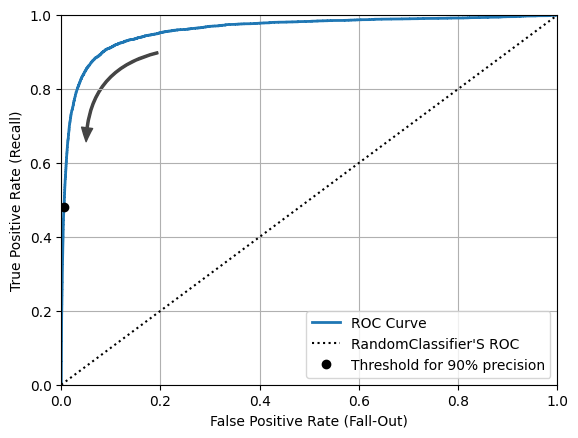

In [31]:
# plot FPR vs TPR
idx_for_threshold_at_90 = (thresholds <= threshold_for_90).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.plot(fpr, tpr, linewidth=2, label="ROC Curve")
plt.plot([0, 1], [0, 1], "k:", label="RandomClassifier'S ROC")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")
plt.gca().axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower right")
plt.xlabel("False Positive Rate (Fall-Out)")
plt.ylabel("True Positive Rate (Recall)")
plt.gca().add_patch(
    patches.FancyArrowPatch(
        (0.20, 0.9),
        (0.05, 0.65),
        connectionstyle="arc3,rad=.4",
        arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
        color="#444444",
    )
)

In [32]:
roc_auc_score(y_tr_5, y_scores)

0.9604938554008616

In [34]:
forest_clf = RandomForestClassifier(random_state=42)

In [35]:
y_probs_fr = cross_val_predict(
    forest_clf, X_train, y_tr_5, cv=3, method="predict_proba"
)

In [36]:
y_probs_fr[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

In [41]:
y_scores_fr = y_probs_fr[:, 1]

precisons_fr, recalls_fr, threshols_fr = precision_recall_curve(y_tr_5, y_scores_fr)

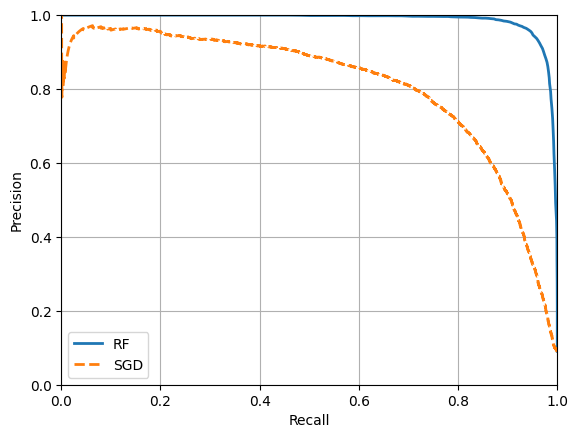

In [46]:
plt.plot(recalls_fr, precisons_fr, linewidth=2, label="RF")
plt.plot(recalls, precisons, "--", linewidth=2, label="SGD")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.gca().axis([0, 1, 0, 1])
plt.grid()

# Multiclass Clasification


In [48]:
svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])

SVC(random_state=42)

`Since
there are 10 classes , Scikit-Learn used the OvO strategy
and trained 45 binary classifiers`


In [51]:
some_digit = X[0]

In [52]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [54]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 3.79297828,  0.72949369,  6.06184129,  8.29800527, -0.29383983,
         9.30157597,  1.74723215,  2.77365456,  7.20601456,  4.82245092]])

In [56]:
class_id = some_digit_scores.argmax()
class_id

5

`When a classifier is trained, it stores the list of target classes in its classes_
attribute, ordered by value. In the case of MNIST, the index of each class in the classes_ array conveniently matches the class itself (e.g., the class at
index 5 happens to be class '5'), but in general you won’t be so lucky
`


In [59]:
# .classes_ is attribute regarding to list of target class
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [60]:
svm_clf.classes_[class_id]

'5'

In [63]:
Ovr_clf = OneVsRestClassifier(SVC(random_state=42))
Ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [65]:
Ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [69]:
# now using SGD
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

In [70]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [73]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# Error Analysis


In [74]:
# plot Confusion Matrix
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

TypeError: ConfusionMatrixDisplay.__init__() takes 2 positional arguments but 3 were given

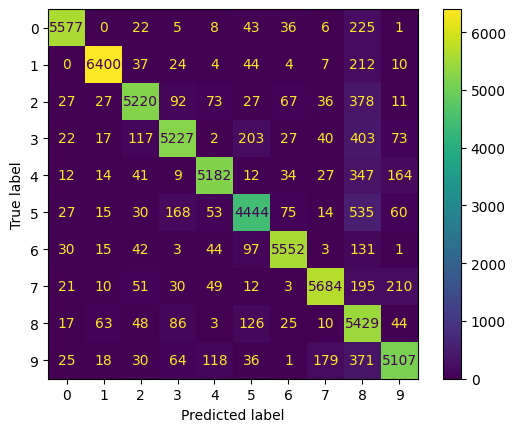

In [75]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)

`Notice that the cell on the diagonal in row #5 and
column #5 looks slightly darker than the other digits. This could be because
the model made more errors on 5s, or because there are fewer 5s in the
dataset than the other digits. That’s why it’s important to normalize the
confusion matrix by dividing each value by the total number of images in the
corresponding (true) class`

`Can be done by setting normalise="true can also specify the values_format=".0%`


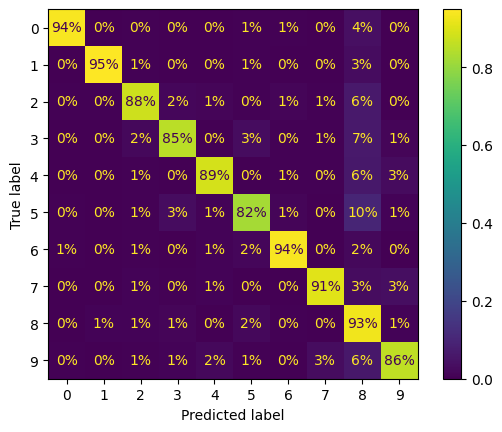

In [77]:
ConfusionMatrixDisplay.from_predictions(
    y_train, y_train_pred, normalize="true", values_format=".0%"
)
# learn to read confusion matrix.... like here 5 is misclassified by 8..how????

# Multilabel Classification


In [78]:
# example


y_train_large = y_train >= "7"
y_train_odd = y_train.astype("int8") % 2 == 1
y_multilabel = np.c_[
    y_train_large, y_train_odd
]  # made a custom array containing two target variables for multilabel classification

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

`This code creates a y_multilabel array containing two target labels for each
digit image: the first indicates whether or not the digit is large (7, 8, or 9), and
the second indicates whether or not it is odd`

`Then the code creates a
KNeighborsClassifier instance, which supports multilabel classification (not
all classifiers do), and trains this model using the multiple targets array.`


In [80]:
knn_clf.predict([X[0]])

array([[False,  True]])

In [88]:
# avg F1 Score [metric]

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

f1_score(y_multilabel, y_train_knn_pred, average="macro")
# if u think all labels are not equally important use "weighted" instead

0.9764102655606048

#### the models can be organized in a chain

`when a model makes a
prediction, it uses the input features plus all the predictions of the models that
come before it in the chain.`


In [90]:
chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

In [91]:
chain_clf.predict([some_digit])

array([[0., 1.]])

# Multioutput Classification


In [105]:
# example Building a system that removes noise from a image
# Input noisy digit
# output clean image of digit
# output is multilabel i.e one label per pixel ranging from 0-255
np.random.seed(42)

noise = np.random.randint(0, 100, size=(len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, size=(len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

`The line between classification and regression is sometimes blurry, such as in this
example. Arguably, predicting pixel intensity is more akin to regression than to
classification. Moreover, multioutput systems are not limited to classification tasks; you
could even have a system that outputs multiple labels per instance, including both class
labels and value labels.`


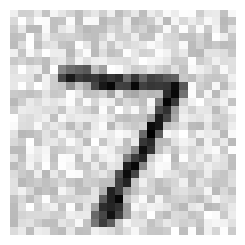

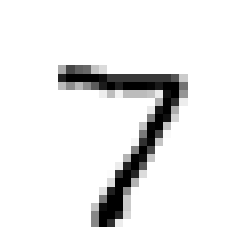

In [106]:
plt.subplot(121)
plot_digit(X_test_mod[0])
plt.subplot(122)
plot_digit(y_test_mod[0])


plt.show()

In [107]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, X_train)

KNeighborsClassifier()

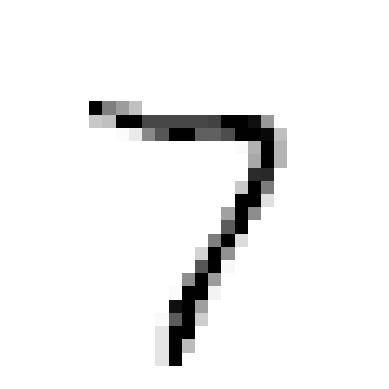

In [108]:
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)